# Searching for Extreme Prontoers

This is a work-in-progress, analyzing the open data from [Pronto Cycle Share's Data Challenge](http://www.prontocycleshare.com/datachallenge).

See [ProntoData.ipynb](ProntoData.ipynb) for an intro to the data; this notebook uses pieces that were derived there.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()

In [2]:
trips = pd.read_csv('2015_trip_data.csv',
                    parse_dates=['starttime', 'stoptime'],
                    infer_datetime_format=True)
t_start = pd.DatetimeIndex(trips['starttime'])
t_stop = pd.DatetimeIndex(trips['stoptime'])
trips['date'] = t_start.date.astype('datetime64')
trips['starttime'] = t_start.time
trips['stoptime'] = t_stop.time
trips['minuteofday'] = t_start.hour * 60 + t_start.minute
trips['minutes'] = trips.tripduration / 60.

In [3]:
stations = pd.read_csv('2015_station_data.csv')
pronto_shop = dict(id=54, name="Pronto shop",
                   terminal="Pronto shop",
                   lat=47.6173156, long=-122.3414776,
                   dockcount=100, online='10/13/2014')
stations = stations.append(pronto_shop, ignore_index=True)
distances = pd.read_csv('station_distances.csv', index_col='terminal')
distances /= 1609.34  # convert meters to miles

In [4]:
trips['distance'] = [distances.loc[ind] for ind in
                     zip(trips.from_station_id, trips.to_station_id)]
trips['speed'] = trips.distance * 60 / trips.minutes

In [5]:
trips.head()

,trip_id,starttime,stoptime,bikeid,tripduration,from_station_name,to_station_name,from_station_id,to_station_id,usertype,gender,birthyear,date,minuteofday,minutes,distance,speed
0,431,10:31:00,10:48:00,SEA00298,985.935,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1960,2014-10-13,631,16.432250,0.455466,1.663069
1,432,10:32:00,10:48:00,SEA00195,926.375,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1970,2014-10-13,632,15.439583,0.455466,1.769994
2,433,10:33:00,10:48:00,SEA00486,883.831,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Female,1988,2014-10-13,633,14.730517,0.455466,1.855194
3,434,10:34:00,10:48:00,SEA00333,865.937,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Female,1977,2014-10-13,634,14.432283,0.455466,1.893531
4,435,10:34:00,10:49:00,SEA00202,923.923,2nd Ave & Spring St,Occidental Park / Occidental Ave S & S Washing...,CBD-06,PS-04,Annual Member,Male,1971,2014-10-13,634,15.398717,0.455466,1.774692


## Distance vs Speed

/Users/jakevdp/anaconda/envs/python3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


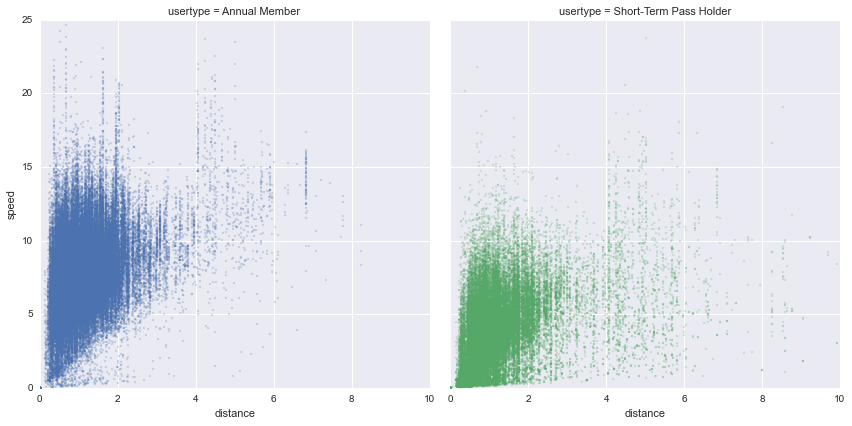

In [6]:
g = sns.FacetGrid(trips, col="usertype", hue='usertype', size=6)
g.map(plt.scatter, "distance", "speed", s=4, alpha=0.2)
g.axes[0, 0].axis([0, 10, 0, 25]);

## Distance vs Count

In [7]:
groups = trips.groupby(['from_station_id', 'to_station_id'])
paired = groups.aggregate({'distance':'mean', 'trip_id':'count',
                           'from_station_name':'first',
                           'to_station_name':'first'})
paired.rename(columns={'trip_id': 'count'}, inplace=True)

In [8]:
countmat = paired['count'].unstack()
total = countmat + countmat.T
total.values.flat[::total.shape[0] + 1] /= 2
paired['total'] = total.stack()

/Users/jakevdp/anaconda/envs/python3.4/lib/python3.4/site-packages/pandas/core/index.py:4281: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


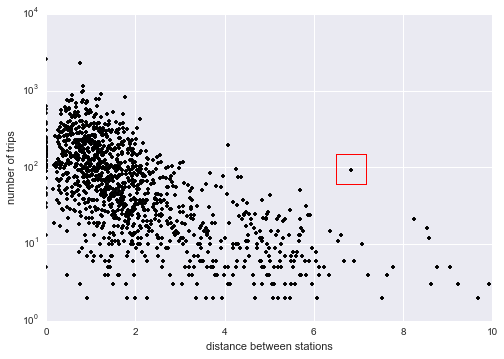

In [9]:
ax = plt.axes(yscale='log')
ax.plot(paired['distance'], paired['total'], '.k')
plt.xlabel('distance between stations')
plt.ylabel('number of trips');
plt.plot(6.83, 95, 's', ms=30, mec='red', mfc='none', mew=1);

In [10]:
station_id_map = trips.groupby('from_station_id')['from_station_name'].first()

def get_group(id1, id2, include_reverse=False):
    query = '(usertype == "Annual Member")'
    
    if include_reverse:
        query += (' & ((from_station_id == "{0}" & to_station_id == "{1}") |'
                 '(from_station_id == "{1}" & to_station_id == "{0}"))')
    else:
        query += ' & (from_station_id == "{0}" & to_station_id == "{1}")'
    return trips.query(query.format(id1, id2))

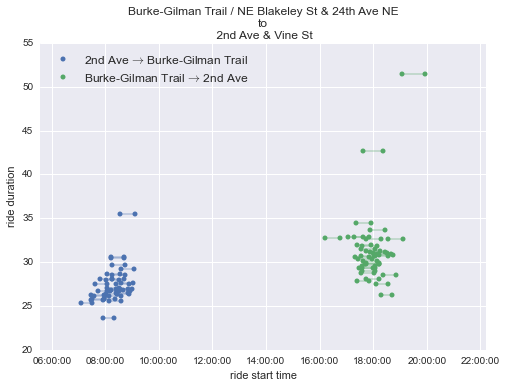

In [11]:
fig, ax = plt.subplots()

id1, id2 = paired.query('distance > 6 & total > 50').reset_index()['from_station_id']
for route in [(id1, id2), (id2, id1)]:
    group = get_group(*route)
    names = station_id_map[route[0]], station_id_map[route[1]]
    lines = ax.plot(group['starttime'], group['minutes'], 'o', ms=5,
                    label="{0} $\\to$ {1}".format(*(' '.join(n.split()[:2]) for n in names)))
    color = lines[0].get_color()
    ax.plot(group['stoptime'], group['minutes'], 'o', ms=5, color=color)
    for i in range(group.shape[0]):
        ax.plot([group['starttime'].values[i], group['stoptime'].values[i]],
                2 * [group['minutes'].values[i]], '-', color=color, alpha=0.3)
    
ax.xaxis.set_major_locator(plt.MultipleLocator(2 * 60 * 60))
ax.legend(loc='best', fontsize=12)
ax.set_title('{0} \nto\n {1}'.format(*names))
ax.set_xlabel('ride start time')
ax.set_ylabel('ride duration');

In [12]:
from sklearn.cluster import MeanShift

def compute_compactness(group, min_samples=25, bandwidth=5):
    """Return a measure of the compactness of the group"""
    # arrange data to cluster: divide minuteofday by 10
    # to increase effective bandwidth by a factor of 10
    X = np.vstack([group.minuteofday / 10,
                   group.minutes]).T
    if X.shape[0] < min_samples:
        return 0

    # compute the meanshift clusters, and count number of points in each
    c = MeanShift(bandwidth=bandwidth).fit_predict(X)
    counts = pd.Series(c).groupby(c).count()
    
    # Select only the points from the dominant cluster
    c = pd.Series(c).map(counts == counts.max())
    
    if c.sum() < min_samples or c.sum() < 0.9 * len(c):
        return 0
    else:
        return bandwidth / X[c.values].std(1).max()
    
compute_compactness(get_group('BT-03', 'UD-01'))

0.41052756897889475

In [13]:
subset = trips.query('usertype == "Annual Member"')
groups = subset.groupby(['from_station_id', 'to_station_id'])
compactness = groups.apply(compute_compactness).fillna(0).unstack()

ranked = compactness.unstack().sort_values(ascending=False)
ranked.iloc[:10]

/Users/jakevdp/anaconda/envs/python3.4/lib/python3.4/site-packages/pandas/core/index.py:4281: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return np.sum(name == np.asarray(self.names)) > 1


to_station_id  from_station_id
UD-01          BT-03              0.410528
UW-10          CH-12              0.349792
               CH-03              0.273353
EL-03          BT-05              0.263845
EL-01          BT-01              0.216928
SLU-18         CH-09              0.206821
BT-04          CH-07              0.195246
EL-03          SLU-18             0.194467
DPD-01         CH-01              0.188177
SLU-04         FH-01              0.185312
dtype: float64

In [14]:
def analyze_pair(id1, id2):
    subset = get_group(id1, id2, True).copy()
    unique = pd.value_counts(subset['birthyear'])
    subset = subset[subset['birthyear'] == unique.index[0]]
    
    def mean_time(col):
        #s = pd.DatetimeIndex(s.astype('datetime64'))
        return np.mean([c.hour * 3600 + c.minute * 60 + c.second
                        for c in col])

    AMPM = subset.groupby('from_station_id')['starttime'].aggregate(mean_time)
    AMPM.sort_values(inplace=True)
    subset['AMPM'] = np.where(subset.from_station_id == np.argmin(AMPM),
                              'morning', 'afternoon')
    
    print('{0} -> {1}'.format(id1, id2))
    print(pd.value_counts(subset['birthyear']))
    print(pd.value_counts(subset['gender']))
    print("distance:", distances.loc[id1, id2])
    print("Date Range:", subset.date.min(), "to", subset.date.max())
    print("-----------------------------")
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
    fig.subplots_adjust(left=0.05, right=0.95, wspace=0.05)
    fig.suptitle('{0} $\longrightarrow$ {1} '
                 ''.format(station_id_map[id1],
                           station_id_map[id2]),
                 size=14)
    
    ax[0].text(0.98, 0.98, "{1:d} total trips\ndistance = {0:.2f} mi".format(distances.loc[id1, id2],
                                                                             len(subset)),
            ha='right', va='top', transform=ax[0].transAxes, fontsize=12)
    
    colors = plt.rcParams['axes.color_cycle']
    for from_station, color in zip(AMPM.index, colors):
        half = subset[subset.from_station_id == from_station]
        station_name = station_id_map[from_station].split('/')[-1]
        ax[0].scatter(half['starttime'].values, half['minutes'].values,
                      c=color, label='from {0}'.format(station_name))
        ax[0].scatter(half['stoptime'].values, half['minutes'].values,
                      c=color)
        for i in range(half.shape[0]):
            ax[0].plot([half['starttime'].values[i], half['stoptime'].values[i]],
                       2 * [half['minutes'].values[i]], '-', color=color, alpha=0.3)
        
    ax[0].legend(loc='lower right', fontsize=14)
    ax[0].xaxis.set_major_locator(plt.MultipleLocator(4 * 60 * 60))
    ax[0].set_ylabel('trip duration (minutes)')
    
    ns_in_day = 24 * 60 * 60 * 1E9
    subset['daynumber'] = (subset.date - subset.date.iloc[0]).astype(int) / ns_in_day
    
    def dateformat(x, *args):
        return str(subset.date.iloc[0] + pd.datetools.timedelta(days=int(x))).split()[0]
    ax[1].xaxis.set_major_locator(plt.MaxNLocator(6))
    ax[1].xaxis.set_major_formatter(plt.FuncFormatter(dateformat))

    for AMPM in ['morning', 'afternoon']:
        sns.regplot('daynumber', 'minutes', data=subset.query('AMPM == "{0}"'.format(AMPM)),
                    ax=ax[1])
    ax[1].set_ylabel('')
    ax[1].set_xlabel('Date')
    ax[1].text(0.98, 0.98, "{0} born in {1}".format(subset['gender'].iloc[0], int(subset['birthyear'].iloc[0])),
               ha='right', va='top', transform=ax[1].transAxes, fontsize=12)
    #ax[1].legend(['morning', 'afternoon'], fontsize=12);

UD-01 -> BT-03
1979    65
Name: birthyear, dtype: int64
Male    65
Name: gender, dtype: int64
distance: 6.82888637578
Date Range: 2015-07-02 00:00:00 to 2015-09-16 00:00:00
-----------------------------


/Users/jakevdp/anaconda/envs/python3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


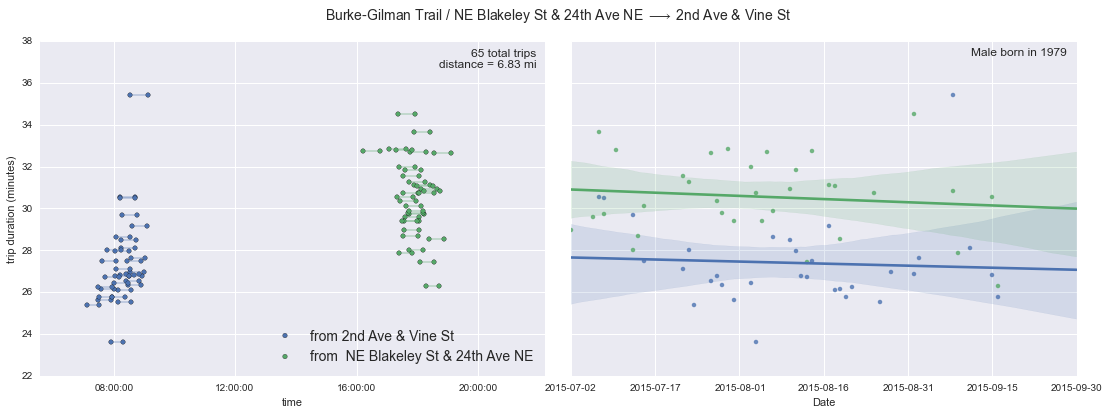

In [15]:
analyze_pair(*ranked.index[0])

UW-10 -> CH-12
1982    57
Name: birthyear, dtype: int64
Male    57
Name: gender, dtype: int64
distance: 3.80217977556
Date Range: 2014-10-20 00:00:00 to 2015-09-10 00:00:00
-----------------------------


/Users/jakevdp/anaconda/envs/python3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


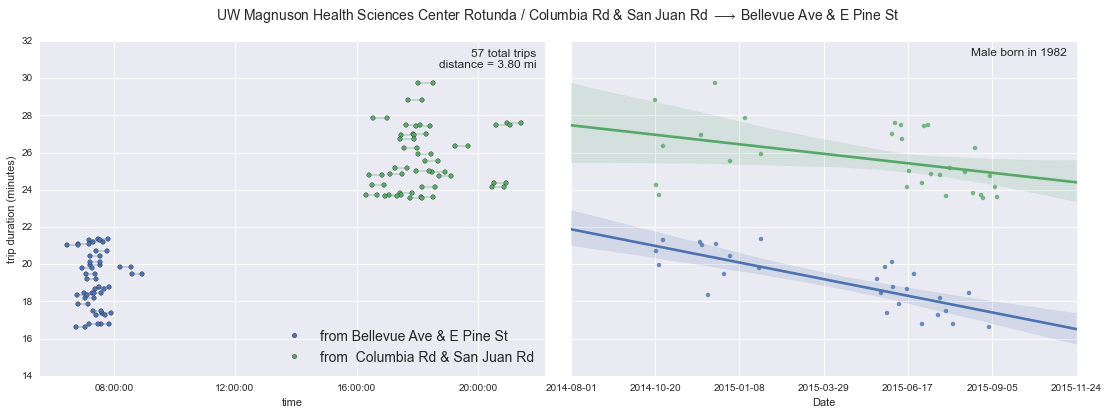

In [16]:
analyze_pair(*ranked.index[1])

EL-03 -> BT-05
1964    288
Name: birthyear, dtype: int64
Female    284
Male        4
Name: gender, dtype: int64
distance: 2.02878198516
Date Range: 2014-10-24 00:00:00 to 2015-10-12 00:00:00
-----------------------------


/Users/jakevdp/anaconda/envs/python3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


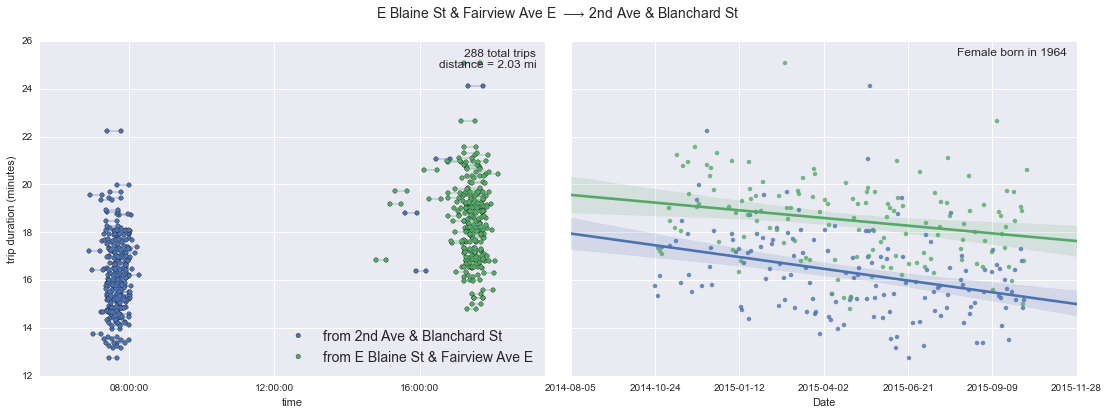

In [17]:
analyze_pair(*ranked.index[3])

EL-01 -> BT-01
1992    145
Name: birthyear, dtype: int64
Female    145
Name: gender, dtype: int64
distance: 1.41983670324
Date Range: 2015-03-02 00:00:00 to 2015-10-12 00:00:00
-----------------------------


/Users/jakevdp/anaconda/envs/python3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


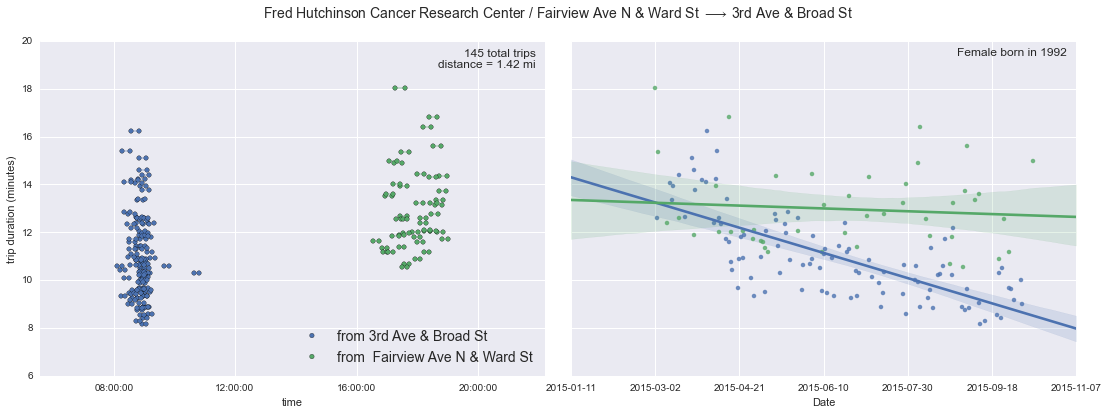

In [18]:
analyze_pair(*ranked.index[4])

EL-03 -> SLU-18
1980    310
Name: birthyear, dtype: int64
Male    310
Name: gender, dtype: int64
distance: 1.66092932506
Date Range: 2014-10-15 00:00:00 to 2015-10-12 00:00:00
-----------------------------


/Users/jakevdp/anaconda/envs/python3.4/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


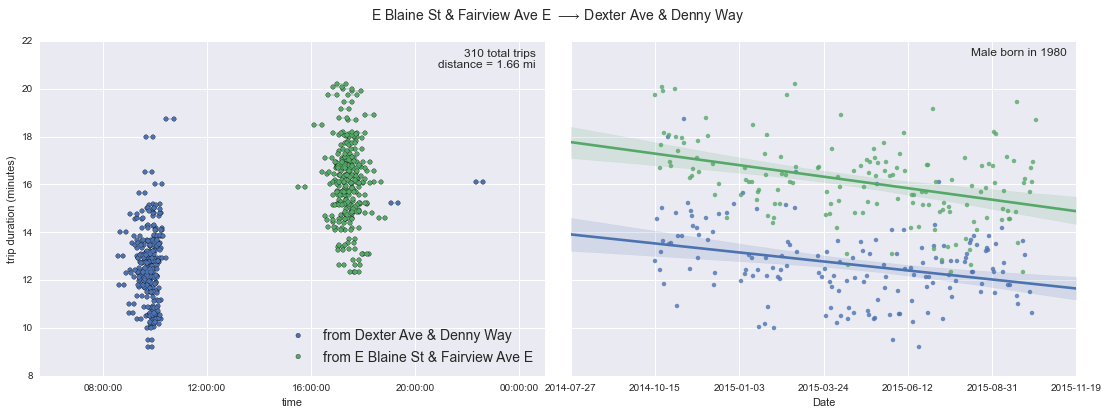

In [19]:
analyze_pair(*ranked.index[7])